## Change sys.path to use my tensortrade instead of the one in env

In [2]:
import sys
sys.path.append("/Users/jasonfiacco/Documents/Yale/Senior/thesis/deeptrader")
print(sys.path)

['/usr/local/opt/python/Frameworks/Python.framework/Versions/3.6/lib/python36.zip', '/usr/local/opt/python/Frameworks/Python.framework/Versions/3.6/lib/python3.6', '/usr/local/opt/python/Frameworks/Python.framework/Versions/3.6/lib/python3.6/lib-dynload', '', '/Users/jasonfiacco/Documents/Yale/Senior/thesis/env/lib/python3.6/site-packages', '/Users/jasonfiacco/Documents/Yale/Senior/thesis/env/lib/python3.6/site-packages/IPython/extensions', '/Users/jasonfiacco/.ipython', '/Users/jasonfiacco/Documents/Yale/Senior/thesis/deeptrader']


## Setup Data Fetching

In [1]:
import ssl
import pandas as pd

ssl._create_default_https_context = ssl._create_unverified_context # Only used if pandas gives a SSLError

def fetch(exchange_name, symbol, timeframe):
    url = "https://www.cryptodatadownload.com/cdd/"
    filename = "{}_{}USD_{}.csv".format(exchange_name, symbol, timeframe)
    volume_column = "Volume {}".format(symbol)
    new_volume_column = "Volume_{}".format(symbol)
    
    df = pd.read_csv(url + filename, skiprows=1)
    df = df[::-1]
    df = df.drop(["Symbol"], axis=1)
    df = df.rename({"Volume USD": "volume", volume_column: new_volume_column}, axis=1)
    df = df.set_index("Date")
    df.columns = [symbol + ":" + name.lower() for name in df.columns]
                     
    return df

## Fetch Historical Data

In [3]:
coinbase_data = pd.concat([
    fetch("Coinbase", "BTC", "1h"),
    fetch("Coinbase", "ETH", "1h")
], axis=1)

In [4]:
coinbase_data.head()

,BTC:open,BTC:high,BTC:low,BTC:close,BTC:volume_btc,BTC:volume,ETH:open,ETH:high,ETH:low,ETH:close,ETH:volume_eth,ETH:volume
Date,,,,,,,,,,,,
2017-07-01 11-AM,2505.56,2513.38,2495.12,2509.17,114.60,287000.32,279.98,279.99,272.1,275.01,2455.28,679358.87
2017-07-01 12-PM,2509.17,2512.87,2484.99,2488.43,157.36,393142.50,275.01,275.01,271.0,274.83,3023.14,824362.87
2017-07-01 01-PM,2488.43,2488.43,2454.40,2454.43,280.28,693254.01,274.83,274.93,265.0,268.79,11204.43,3010787.99
2017-07-01 02-PM,2454.43,2473.93,2450.83,2459.35,289.42,712864.80,268.79,269.90,265.0,265.74,6367.05,1702536.85
2017-07-01 03-PM,2459.35,2475.00,2450.00,2467.83,276.82,682105.41,265.74,272.74,265.0,272.57,5581.66,1500282.55


## Define Exchanges

An exchange needs a name, an execution service, and streams of price data in order to function properly.

The setups supported right now are the simulated execution service using simulated or stochastic data. More execution services will be made available in the future, as well as price streams so that live data and execution can be supported.

In [5]:
from tensortrade.exchanges import Exchange
from tensortrade.exchanges.services.execution.simulated import execute_order
from tensortrade.data import Stream

#Exchange(name of exchange, service)
#It looks like each Stream takes a name, and then a list of the closing prices.

coinbase = Exchange("coinbase", service=execute_order)(
    Stream("USD-BTC", list(coinbase_data['BTC:close'])),
    Stream("USD-ETH", list(coinbase_data['ETH:close']))
)


Now that the exchanges have been defined we can define our features that we would like to include, excluding the prices we have provided for the exchanges.

## Define External Data Feed

Here we will define the external feed to use whatever data you would like. From financial indicators to datasets that have nothing to do with instrument prices, they will all have to be defined and incorporated into the external data feed provided to the environment. There is also an internal data feed that is used to collect data on all the wallets and the net worth of the portfolio. You can choose to include this or not by using the `use_internal` parameter of the trading environment.

In [6]:
#This is where we can add other features like technical analysis to help our agent. 
#This is where you would add news.

#Import ta, which is a technical analysis finance package.
import ta
from tensortrade.data import DataFeed, Module

# Add all features for coinbase bitcoin
#First subset the full dataframe to get just data for BTC, and then just data for ETH
coinbase_btc = coinbase_data.loc[:, [name.startswith("BTC") for name in coinbase_data.columns]]
coinbase_eth = coinbase_data.loc[:, [name.startswith("ETH") for name in coinbase_data.columns]]

#Now add all the TA extra features for bitcoin.
ta.add_all_ta_features(
    coinbase_btc,
    colprefix="BTC:",
    **{k: "BTC:" + k for k in ['open', 'high', 'low', 'close', 'volume']}
)

#Add streams for all the other columns, not just Closing prices like we did for the Exchange.
#This time we are adding "Streams" for "High", "Low", "OBV, "CMB", NVI, etc. to a "Feed" instead
#of an "Exchange"
with Module("coinbase") as coinbase_ns:
    coinbase_nodes = [Stream(name, list(coinbase_btc[name])) for name in coinbase_btc.columns]
    coinbase_nodes += [Stream(name, list(coinbase_eth[name])) for name in coinbase_eth.columns]


feed = DataFeed([coinbase_ns])

/Users/jasonfiacco/Documents/Yale/Senior/thesis/env/lib/python3.6/site-packages/ta/wrapper.py:47: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/jasonfiacco/Documents/Yale/Senior/thesis/env/lib/python3.6/site-packages/ta/wrapper.py:51: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/jasonfiacco/Documents/Yale/Senior/thesis/env/lib/python3.6/site-packages/ta/wrapper.py:55: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_in

In [7]:
feed.next()

{'coinbase:/BTC:open': 2505.56,
 'coinbase:/BTC:high': 2513.38,
 'coinbase:/BTC:low': 2495.12,
 'coinbase:/BTC:close': 2509.17,
 'coinbase:/BTC:volume_btc': 114.6,
 'coinbase:/BTC:volume': 287000.32,
 'coinbase:/BTC:volume_adi': 154659.5371741516,
 'coinbase:/BTC:volume_obv': 287000.32,
 'coinbase:/BTC:volume_cmf': 0.5388828039430464,
 'coinbase:/BTC:volume_fi': nan,
 'coinbase:/BTC:volume_em': nan,
 'coinbase:/BTC:volume_sma_em': nan,
 'coinbase:/BTC:volume_vpt': -188178.85169821125,
 'coinbase:/BTC:volume_nvi': 1000.0,
 'coinbase:/BTC:volatility_atr': 0.0,
 'coinbase:/BTC:volatility_bbm': 2509.17,
 'coinbase:/BTC:volatility_bbh': 2509.17,
 'coinbase:/BTC:volatility_bbl': 2509.17,
 'coinbase:/BTC:volatility_bbw': 0.0,
 'coinbase:/BTC:volatility_bbhi': 0.0,
 'coinbase:/BTC:volatility_bbli': 0.0,
 'coinbase:/BTC:volatility_kcc': 2505.89,
 'coinbase:/BTC:volatility_kch': 2505.89,
 'coinbase:/BTC:volatility_kcl': 2487.6299999999997,
 'coinbase:/BTC:volatility_kchi': 0.0,
 'coinbase:/BTC:v

### Doing it without adding other features. Just use price 

In [8]:
#You still have to add "Streams" for all the standard columns open, high, low, close, volume in this case
with Module("coinbase") as coinbase_ns:
    coinbase_nodes = [Stream(name, list(coinbase_data[name])) for name in coinbase_data.columns]

In [9]:
#Then create the Feed from it
feed = DataFeed([coinbase_ns])
feed.next()

{'coinbase:/BTC:open': 2505.56,
 'coinbase:/BTC:high': 2513.38,
 'coinbase:/BTC:low': 2495.12,
 'coinbase:/BTC:close': 2509.17,
 'coinbase:/BTC:volume_btc': 114.6,
 'coinbase:/BTC:volume': 287000.32,
 'coinbase:/ETH:open': 279.98,
 'coinbase:/ETH:high': 279.99,
 'coinbase:/ETH:low': 272.1,
 'coinbase:/ETH:close': 275.01,
 'coinbase:/ETH:volume_eth': 2455.28,
 'coinbase:/ETH:volume': 679358.87}

## Portfolio

Make the portfolio using the any combinations of exchanges and intruments that the exchange supports

In [10]:
#I am going to have to add "instruments" for all 25 of the PredictIt markets I'm working with.
from tensortrade.instruments import USD, BTC, ETH
from tensortrade.wallets import Wallet, Portfolio

portfolio = Portfolio(USD, [
    Wallet(coinbase, 10000 * USD),
    Wallet(coinbase, 0 * BTC),
    Wallet(coinbase, 0 * ETH)
])

### Create the "price_history" object that is necessary for the renderer

In [11]:
#Make "dataset" so that we can get price-history
dataset = ta.add_all_ta_features(coinbase_data, 'BTC:open', 'BTC:high', 'BTC:low', 'BTC:close', 'BTC:volume', fillna=True)
dataset2 = dataset.reset_index(level=0, inplace=False)
dataset2.head(3)

,Date,BTC:open,BTC:high,BTC:low,BTC:close,BTC:volume_btc,BTC:volume,ETH:open,ETH:high,ETH:low,...,momentum_uo,momentum_stoch,momentum_stoch_signal,momentum_wr,momentum_ao,momentum_kama,momentum_roc,others_dr,others_dlr,others_cr
0,2017-07-01 11-AM,2505.56,2513.38,2495.12,2509.17,114.60,287000.32,279.98,279.99,272.1,...,50.0,76.944140,76.944140,-23.055860,0.0,2509.17,0.0,-65.658199,0.000000,0.000000
1,2017-07-01 12-PM,2509.17,2512.87,2484.99,2488.43,157.36,393142.50,275.01,275.01,271.0,...,50.0,12.116943,44.530541,-87.883057,0.0,2488.43,0.0,-0.826568,-0.830003,-0.826568
2,2017-07-01 01-PM,2488.43,2488.43,2454.40,2454.43,280.28,693254.01,274.83,274.93,265.0,...,50.0,0.050865,29.703982,-99.949135,0.0,2454.43,0.0,-1.366323,-1.375743,-2.181598


In [12]:
#Define price_history for the rendering
price_history = dataset2[['Date', 'BTC:open', 'BTC:high', 'BTC:low', 'BTC:close', 'BTC:volume']]
price_history.head(3)

,Date,BTC:open,BTC:high,BTC:low,BTC:close,BTC:volume
0,2017-07-01 11-AM,2505.56,2513.38,2495.12,2509.17,287000.32
1,2017-07-01 12-PM,2509.17,2512.87,2484.99,2488.43,393142.50
2,2017-07-01 01-PM,2488.43,2488.43,2454.40,2454.43,693254.01


## Environment

In [13]:
from tensortrade.environments import TradingEnvironment

env = TradingEnvironment(
    feed=feed,
    portfolio=portfolio,
    action_scheme='managed-risk',
    reward_scheme='simple',
    window_size=15,
    enable_logger=False,
    price_history = price_history,
    renderers = 'screenlog'
)

/Users/jasonfiacco/Documents/Yale/Senior/thesis/env/lib/python3.6/site-packages/gym/logger.py:30: UserWarning:

WARN: Box bound precision lowered by casting to float32



In [14]:
env.feed.next()

{'coinbase:/BTC:open': 2505.56,
 'coinbase:/BTC:high': 2513.38,
 'coinbase:/BTC:low': 2495.12,
 'coinbase:/BTC:close': 2509.17,
 'coinbase:/BTC:volume_btc': 114.6,
 'coinbase:/BTC:volume': 287000.32,
 'coinbase:/ETH:open': 279.98,
 'coinbase:/ETH:high': 279.99,
 'coinbase:/ETH:low': 272.1,
 'coinbase:/ETH:close': 275.01,
 'coinbase:/ETH:volume_eth': 2455.28,
 'coinbase:/ETH:volume': 679358.87,
 'coinbase:/USD-BTC': 2509.17,
 'coinbase:/USD-ETH': 275.01,
 'coinbase:/USD:/free': 10000,
 'coinbase:/USD:/locked': 0,
 'coinbase:/USD:/total': 10000,
 'coinbase:/BTC:/free': 0,
 'coinbase:/BTC:/locked': 0,
 'coinbase:/BTC:/total': 0,
 'coinbase:/BTC:/worth': 0.0,
 'coinbase:/ETH:/free': 0,
 'coinbase:/ETH:/locked': 0,
 'coinbase:/ETH:/total': 0,
 'coinbase:/ETH:/worth': 0.0,
 'net_worth': 10000.0}

#### ^An environment doesn't just show the OHLCV for each instrument. It also shows free, locked, total, as well as "USD_BTC"

### Make and train the agent

In [15]:
from tensortrade.agents import DQNAgent

agent = DQNAgent(env)
agent.train(n_episodes=2, n_steps=1, render_interval=100)

====      AGENT ID: f0a598fc-1e92-450e-b849-773bfb3bf63a      ====
[2020-02-21 16:09:09] Episode: 1/2 - Step: 128/1
[2020-02-21 16:09:09] Episode: 2/2 - Step: 1/1


-0.003328006606906575

## Plot

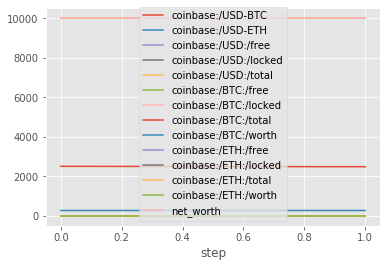

In [16]:
%matplotlib inline

portfolio.performance.plot()

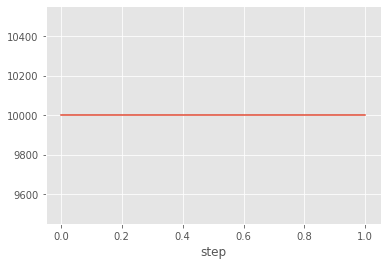

In [17]:
portfolio.performance.net_worth.plot()

## Try Plotly Render too

In [24]:
from tensortrade.environments.render import PlotlyTradingChart
from tensortrade.environments.render import FileLogger

chart_renderer = PlotlyTradingChart(
    height = 800
)

file_logger = FileLogger(
    filename='example.log',  # omit or None for automatic file name
    path='training_logs'  # create a new directory if doesn't exist, None for no directory
)

In [30]:
price_history.columns = ['datetime', 'open', 'high', 'low', 'close', 'volume']

In [31]:
env = TradingEnvironment(
    feed=feed,
    portfolio=portfolio,
    action_scheme='managed-risk',
    reward_scheme='risk-adjusted',
    window_size=20,
    price_history=price_history,
    renderers = [chart_renderer, file_logger]
)

/Users/jasonfiacco/Documents/Yale/Senior/thesis/env/lib/python3.6/site-packages/gym/logger.py:30: UserWarning:

WARN: Box bound precision lowered by casting to float32



In [ ]:
from tensortrade.agents import DQNAgent

agent = DQNAgent(env)
agent.train(n_episodes=1, n_steps=1000, render_interval=1)

FigureWidget({
    'data': [{'close': array([2509.17, 2488.43, 2454.43, ..., 2026.65, 1964.31, 1954.7 ]),
    …